In [1]:
# Launch 7 parallel processes and load module in all
addprocs(7)
import QuantumBayesian
@everywhere using QuantumBayesian

using PyPlot

# One Qubit Stochastic Monitoring Test

**Justin Dressel**, Jan 4, 2016 <br />
*Institute for Quantum Studies, Chapman University*

Using a simple qubit Rabi oscillation problem, test whether the Quantum Bayesian update code for Julia produce sensible results for the simplest quantum problem of monitoring the observable of a single qubit.

## Problem Specification

Consider a qubit orbiting in the x-z plane of the Bloch sphere with unit period, with continuous monitoring of the z and/or y observables.

In [2]:
# Ensure qubit and Bloch coordinate functions are defined on all processes for parallelization
@everywhere q = qubit()
@everywhere x(ρ) = real(expect(ρ, q("x")));
@everywhere y(ρ) = real(expect(ρ, q("y")));
@everywhere z(ρ) = real(expect(ρ, q("z")));

In [3]:
@everywhere Ω  = 2*π;        # Rabi frequency, unit period
τ = 3.0;         # Measurement collapse timescale (given quantum-limited efficiency)
Γ = 1/(2*τ);     # Measurement dephasing rate
T = (0.0, 3*τ);  # Time duration of simulation;

# Hamiltonian: oscillations in x-z plane
H = (Ω/2)*q("y");

# Initial ground state
ρ0 = ground(q);

Below is convenience code for plotting purposes -- it is safe to skip to the next section.

In [4]:
function plot_solution(sol; plot_title="Monitored Rabi Oscillation", readout=false, ymeas=false, stds=[])
    # Plot Bloch components vs. time
    figure(1)
    ax = gca()
    ax[:set_ylim]([-1.1,1.1])
    hold(true)
    plot(sol[1].t, sol[1], label=L"$x$", color="r")
    plot(sol[2].t, sol[2], label=L"$y$", color="g")
    plot(sol[3].t, sol[3], label=L"$z$", color="b")
    if length(stds) > 0
        fill_between(sol[1].t, sol[1]-stds[1], sol[1]+stds[1], color="r", alpha=0.2, antialiased=true)
        fill_between(sol[2].t, sol[2]-stds[2], sol[2]+stds[2], color="g", alpha=0.2, antialiased=true)
        fill_between(sol[3].t, sol[3]-stds[3], sol[3]+stds[3], color="b", alpha=0.2, antialiased=true)
    end
    xlabel(L"$t\,\nu$")
    ylabel("Bloch coordinates")
    title(plot_title)
    legend()
    hold(false)
    show()
    if readout
        figure(2)
        hold(true)
        plot(sol[4].t, sol[4], label=L"$r_z$", color="b")
        ymeas && plot(sol[5].t, sol[5], label=L"$r_y$", color="g")
        if length(stds) > 0
            fill_between(sol[4].t, sol[4]-stds[4], sol[4]+stds[4], color="b", alpha=0.2, antialiased=true)
            ymeas && fill_between(sol[5].t, sol[5]-stds[5], sol[5]+stds[5], color="g", alpha=0.2, antialiased=true)
        end
        xlabel(L"$t\,\nu$")
        ylabel("Stochastic Readout")
        title(plot_title*" Readout")
        legend()
        hold(false)
        show()
    end
end;

## Reference Lindblad Dynamics

First we benchmark pure Lindblad dephasing, to get a reference for the average dynamics and calibrate a reference speed.

Note that this Lindblad simulation corresponds to the master equation ($\hbar=1$):
$$ \dot{\rho} = -i[H,\,\rho] + \frac{\Gamma}{2}\left[\sigma_z\,\rho\,\sigma_z^\dagger - \frac{\{\sigma_z^\dagger\sigma_z,\, \rho\}}{2}\right] $$
with a similar dissipation term for $\sigma_y$ if both axes have dephasing.

In [5]:
# Measurement dephasing
DMz = sqrt(Γ/2)*q("z");
DMy = sqrt(Γ/2)*q("y");
@everywhere DM(t) = cos(2*Ω*t).*DMz + sin(2*Ω*t).*DMy;

# Deterministic averaged evolution (Lindblad equation)
function ensemble_average(; Δt=1/10^2, ymeas=false, tmeas=false, verbose=true)
    # Jump/no-jump Lindblad simulation
    inc = lind(Δt, H, clist=[DMz])
    ymeas && (inc = lind(Δt, H, clist=[DMz, DMy]))
    tmeas && (inc = lind(Δt, H, flist=[DM]))
    # Keep all simulated points
    trajectory(inc, ρ0, T, x, y, z; dt=Δt, points=Int((last(T)-first(T))/Δt), verbose=verbose)
end;

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Time elapsed: 0.049528573 s, Steps per second: 18151.138737633326


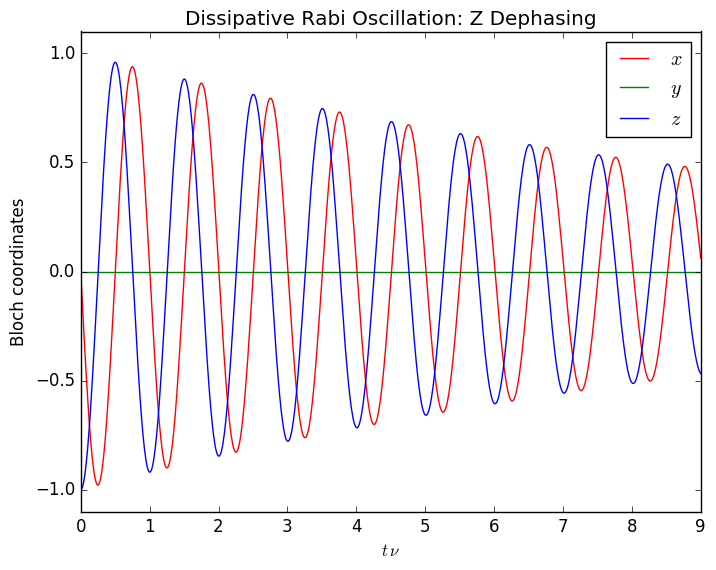

In [6]:
sol = ensemble_average(verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_average()
plot_solution(sol, plot_title="Dissipative Rabi Oscillation: Z Dephasing")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Time elapsed: 0.069785144 s, Steps per second: 12882.398007232028


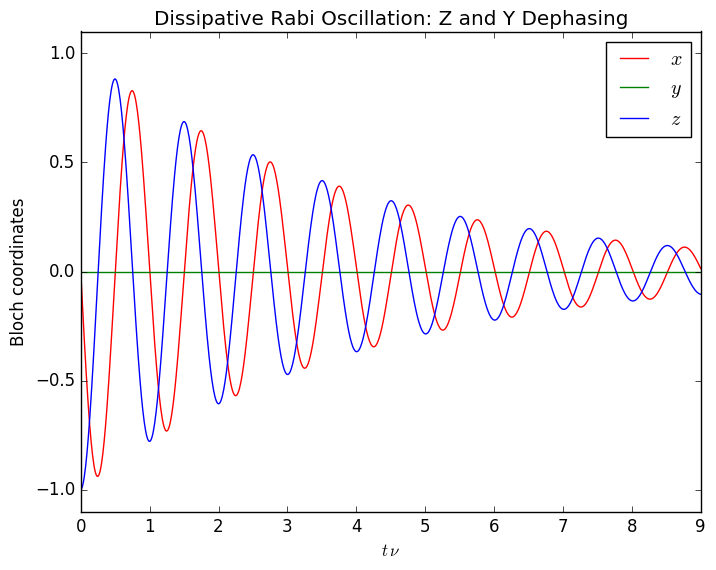

  0.070315 seconds (336.09 k allocations: 28.748 MB, 4.82% gc time)


In [7]:
sol = ensemble_average(ymeas=true, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_average(ymeas=true)
plot_solution(sol, plot_title="Dissipative Rabi Oscillation: Z and Y Dephasing")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Time elapsed: 0.159775756 s, Steps per second: 5626.635870838878


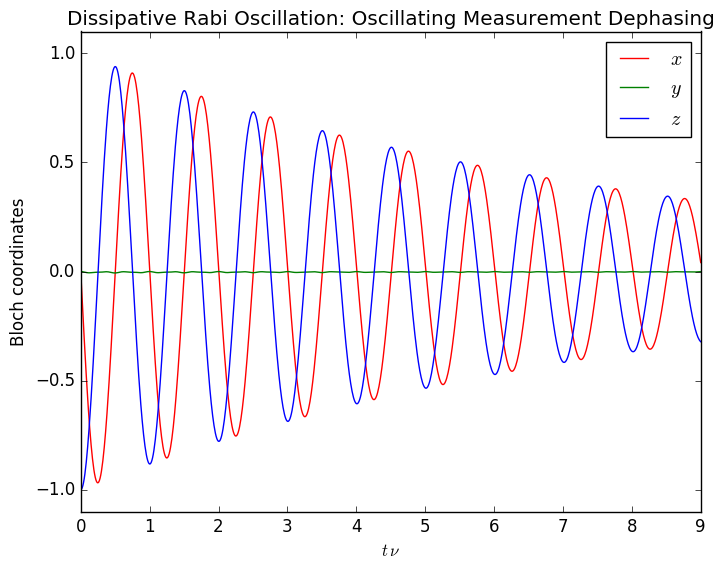

  0.160442 seconds (671.43 k allocations: 51.481 MB, 3.44% gc time)


In [8]:
sol = ensemble_average(tmeas=true, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_average(tmeas=true)
plot_solution(sol, plot_title="Dissipative Rabi Oscillation: Oscillating Measurement Dephasing")

## Stochastic Dynamics Tests

Now we examine single trajectories and ensembles of trajectories carefully, to make sure they agree with the ensemble-averaged Lindblad dynamics.

Note that this simulation corresponds to the stochastic master equation:
$$ d\rho = -i[H,\,\rho]dt + \frac{\Gamma}{2}\left[\sigma_z\,\rho\,\sigma_z^\dagger - \frac{\{\sigma_z^\dagger\sigma_z,\, \rho\}}{2}\right]dt + \sqrt{\frac{\eta\,\Gamma}{2}}\left[\sigma_z\,e^{-i\phi}\,\rho + \rho\,\sigma_z^\dagger\,e^{i\phi} - \langle\sigma_z\,e^{-i\phi} + \sigma_z^\dagger\,e^{i\phi}\rangle\,\rho\right]dW $$

This can be rewritten in an elegant and more useful way for simulation using the collapse time $\tau = 1/(2\,\Gamma\,\eta)$ by defining the collapse operator
$$ A \equiv \sigma_z\,e^{-i\phi} \equiv A_r - i\, A_i $$
whose real (Hermitian) part corresponds to the measured observable, and whose imaginary (anti-Hermitian) part corresponds to the phase back-action. 

This collapse operator produces a single Kraus operator that governs the total back-action from the collected signal:
$$ M_r = \left(\frac{dt}{2\pi\tau}\right)^{1/4}\,\exp\left[ -i\,\frac{dt\,A_i}{2\tau}\, -\, \frac{dt\,(r-A_r)^2}{4\tau} \right] \propto \exp\left[\frac{dt\,A}{2\tau} - \frac{dt\,A_r^2}{4\tau}\right]$$

The signal $r$ is sampled from the probability distribution $P(r\,|\,\rho) = \text{Tr}[\rho\,M_r^\dagger M_r]$. It is easy to show that this results in the approximate moving-mean white-noise relation : 
$$r\,dt = \langle A_r \rangle\,dt + \sqrt{\tau}\,dW$$

In addition to this back-action, there is residual Lindblad dephasing that occurs at the modified rate:
$$ \gamma = \Gamma - \frac{1}{2\tau} = \frac{1-\eta}{2\,\tau\,\eta} $$

Such residual dephasing can be easily modeled separately using the jump/no-jump unraveling of the Lindblad equation:
$$ \rho(t+dt) = \frac{\gamma\,dt}{2}\,\sigma_z\,\rho(t)\,\sigma_z^\dagger + \sqrt{1 - \frac{\gamma\,dt}{2}\sigma_z^\dagger\sigma_z}\,\rho(t)\,\sqrt{1 - \frac{\gamma\,dt}{2}\sigma_z^\dagger\sigma_z} $$

This complete unraveling into exact discrete-step Kraus operators has the enormous benefit of being a valid completely positive map that preserves the properties of the state. Other methods for integrating the stochastic master equation do not converge in precision easily, comparatively.

In [9]:
function ensemble_realization(; Δt=1/10^2, η=1.0, n=1, ymeas=false, tmeas=false, ϕ=0.0, verbose=true)
    # Monitoring with tunable quantum efficiency
    inc = meas(Δt, H, mclist=[(exp(-im*ϕ).*q("z"), τ/η, η)])
    ymeas && (inc = meas(Δt, H, mclist=[(exp(-im*ϕ).*q("z"), τ/η, η), (exp(-im*ϕ).*q("y"), τ/η, η)]))
    tmeas && (inc = meas(Δt, H, mflist=[(t -> cos(2*Ω*t).*exp(-im*ϕ).*q("z") + sin(2*Ω*t).*exp(-im*ϕ).*q("y"), τ/η, η)]))
    # Choose one trajectory or an ensemble, accordingly
    if n==1
        trajectory(inc, ρ0, T, x, y, z; dt=Δt, points=Int((last(T)-first(T))/Δt), verbose=verbose, readout=true)
    else
        ensemble(n, inc, ρ0, T, x, y, z; dt=Δt, points=Int((last(T)-first(T))/Δt), verbose=verbose, readout=true)
    end
end;

### Single Trajectory Examples

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.029089891 s, Steps per second: 30904.206550653627


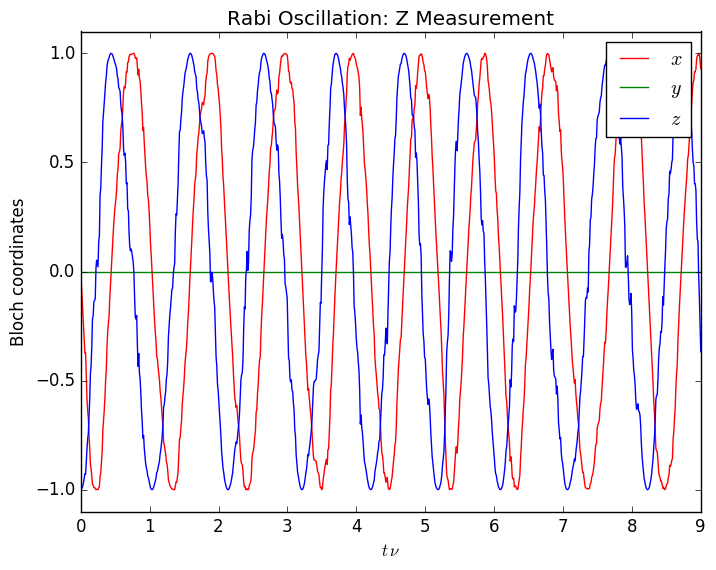

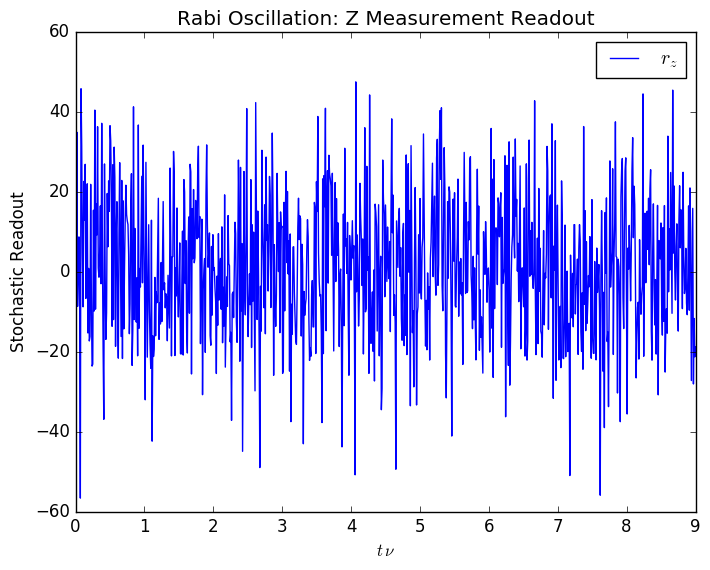

In [10]:
sol = ensemble_realization(verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization()
plot_solution(sol, readout=true, plot_title="Rabi Oscillation: Z Measurement")

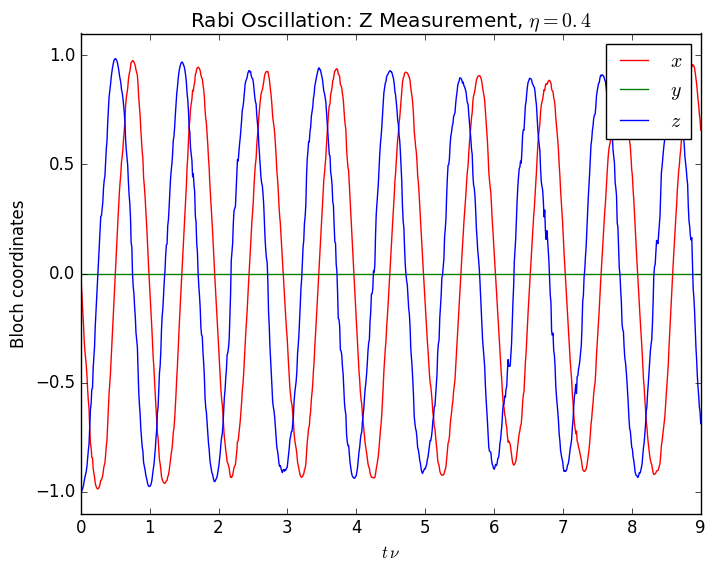

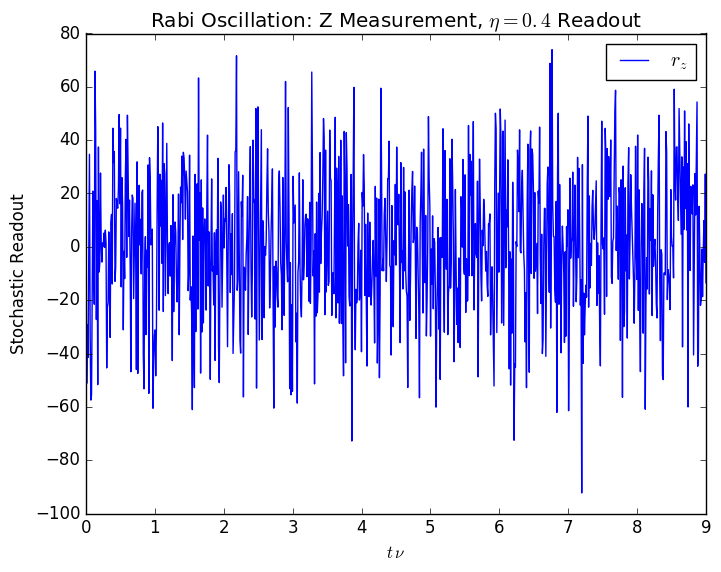

  0.076965 seconds (357.60 k allocations: 31.030 MB, 8.23% gc time)


INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.075722907 s, Steps per second: 11872.233061522584


In [11]:
sol = ensemble_realization(η=0.4,verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(η=0.4)
plot_solution(sol, readout=true, plot_title=L"Rabi Oscillation: Z Measurement, $\eta=0.4$")

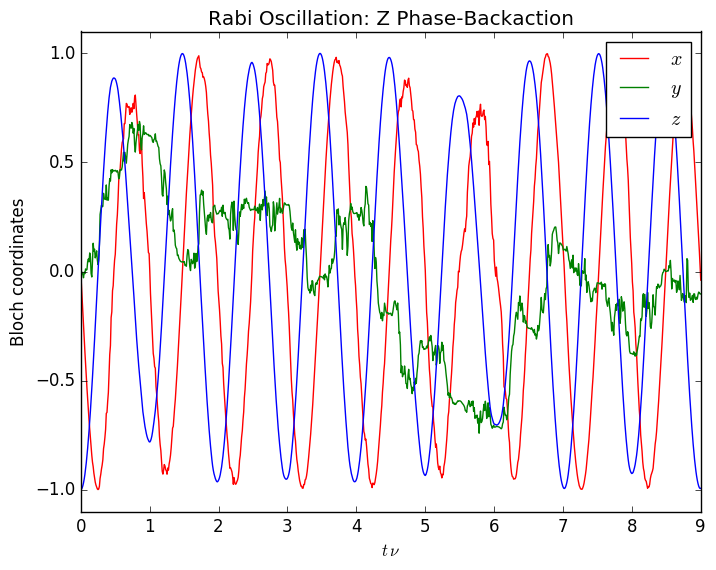

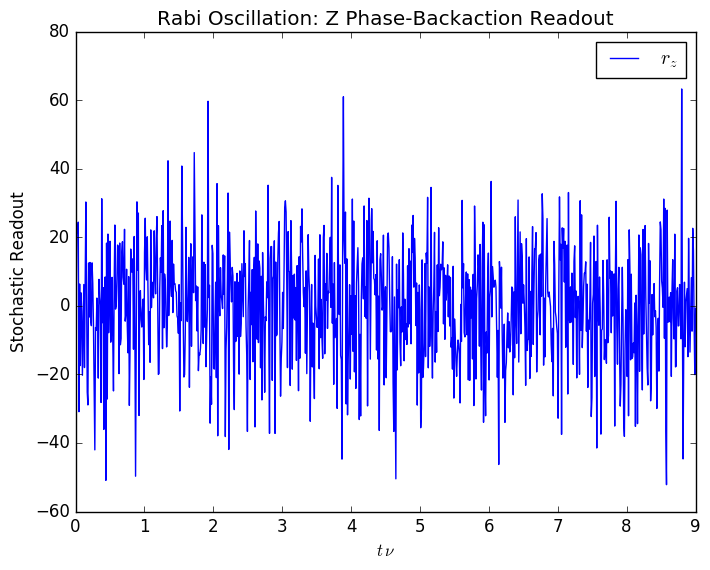

  0.040744 seconds (222.42 k allocations: 14.700 MB)


INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1
INFO: Time elapsed: 0.039137511 s, Steps per second: 22970.290573664737


In [12]:
sol = ensemble_realization(ϕ=π/2, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ϕ=π/2)
plot_solution(sol, readout=true, plot_title="Rabi Oscillation: Z Phase-Backaction")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1


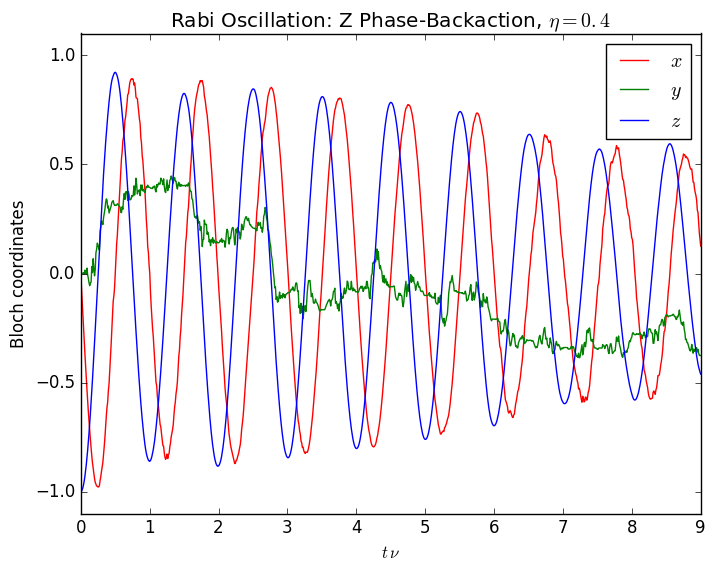

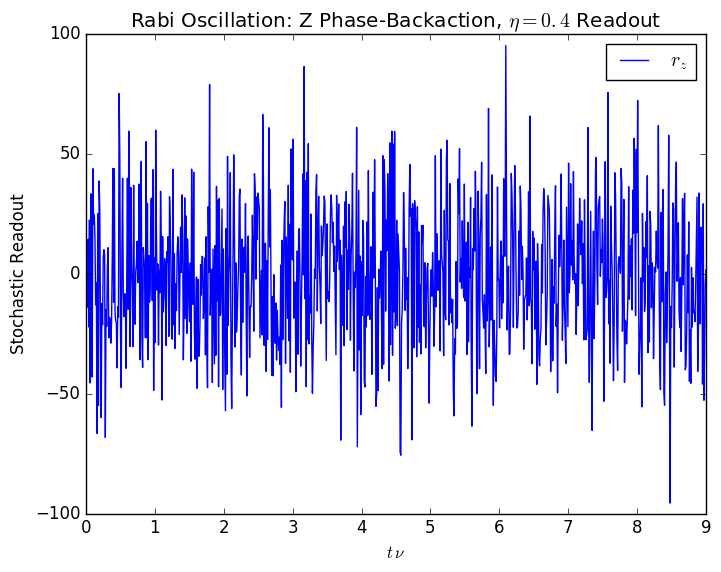

  0.096239 seconds (368.92 k allocations: 30.790 MB, 8.49% gc time)


INFO: Time elapsed: 0.094923846 s, Steps per second: 9470.749847198564


In [13]:
sol = ensemble_realization(ϕ=π/2, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ϕ=π/2, η=0.4)
plot_solution(sol, readout=true, plot_title=L"Rabi Oscillation: Z Phase-Backaction, $\eta=0.4$")

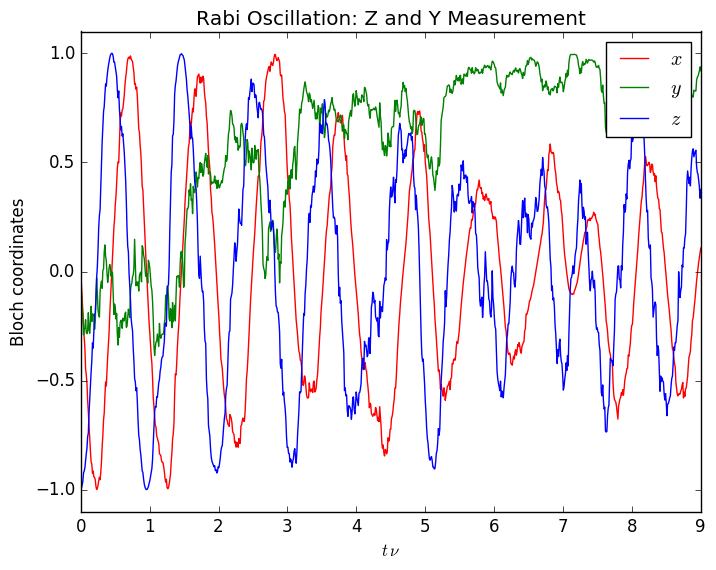

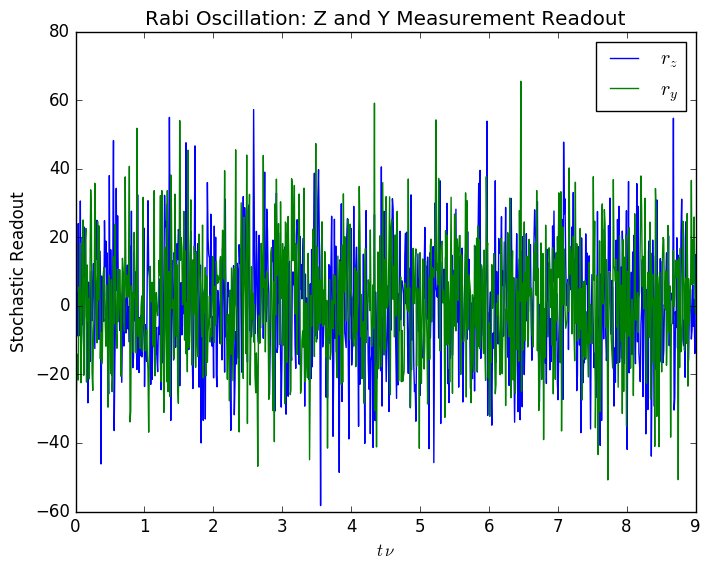

  0.066057 seconds (304.34 k allocations: 22.911 MB, 5.40% gc time)


INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2
INFO: Time elapsed: 0.063521213 s, Steps per second: 14152.752404145682


In [14]:
sol = ensemble_realization(ymeas=true, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true)
plot_solution(sol, readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Measurement")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2


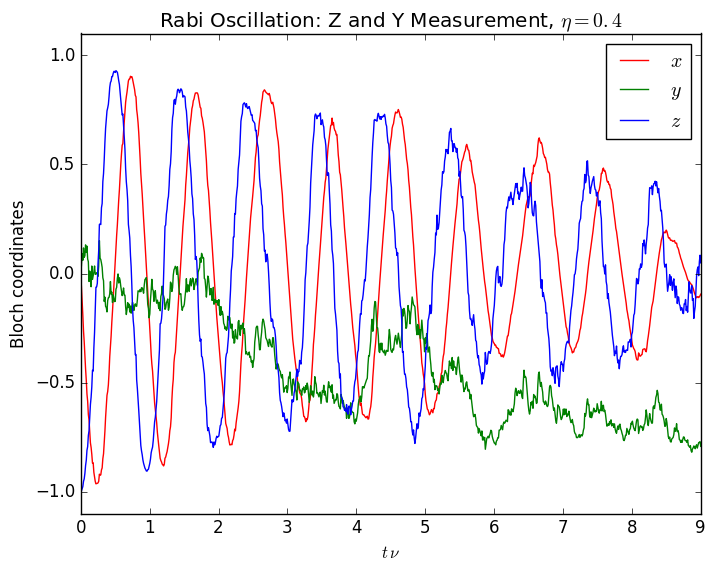

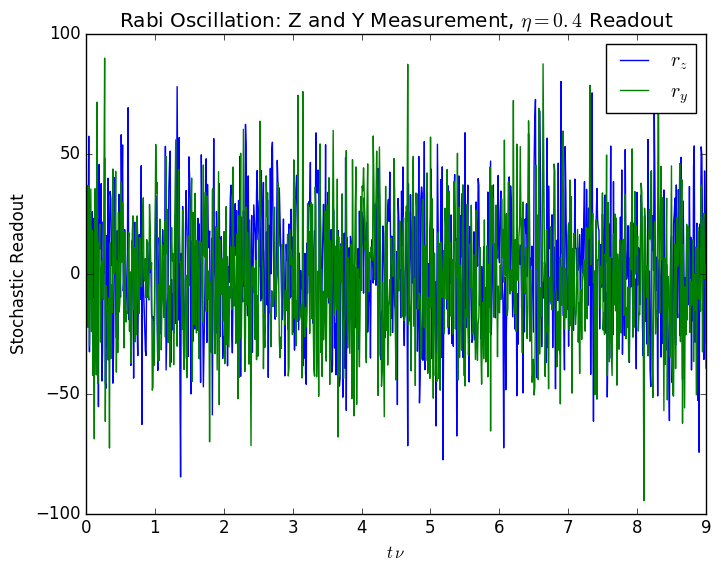

  0.117164 seconds (548.98 k allocations: 45.775 MB, 4.82% gc time)


INFO: Time elapsed: 0.115956646 s, Steps per second: 7752.897578634691


In [15]:
sol = ensemble_realization(ymeas=true, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true, η=0.4)
plot_solution(sol, readout=true, ymeas=true, plot_title=L"Rabi Oscillation: Z and Y Measurement, $\eta=0.4$")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2


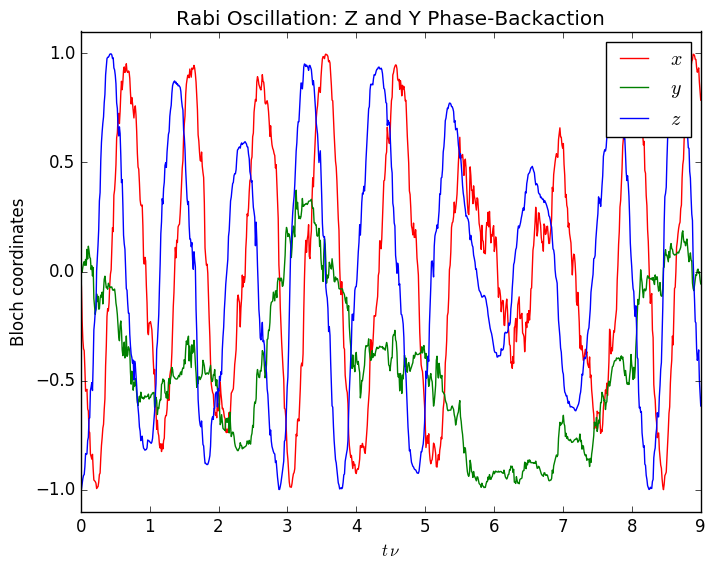

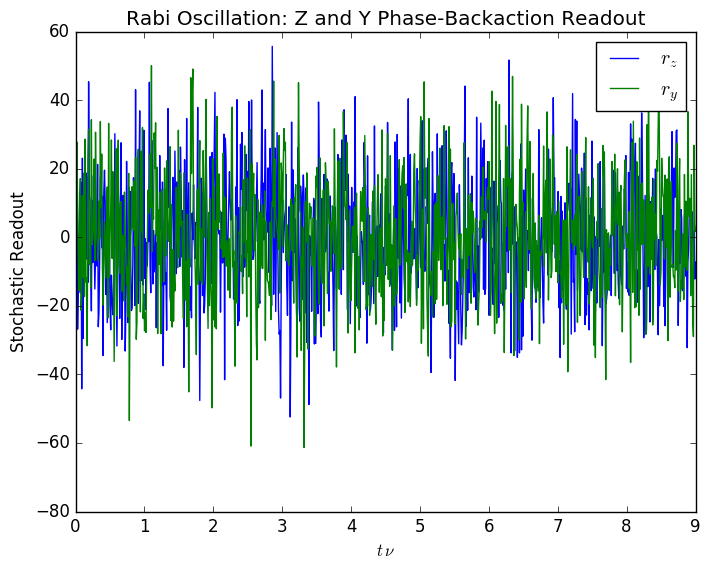

  0.046804 seconds (329.29 k allocations: 22.699 MB, 6.20% gc time)


INFO: Time elapsed: 0.045639297 s, Steps per second: 19697.937065069164


In [16]:
sol = ensemble_realization(ymeas=true, ϕ=π/2, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true, ϕ=π/2)
plot_solution(sol, readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Phase-Backaction")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 2


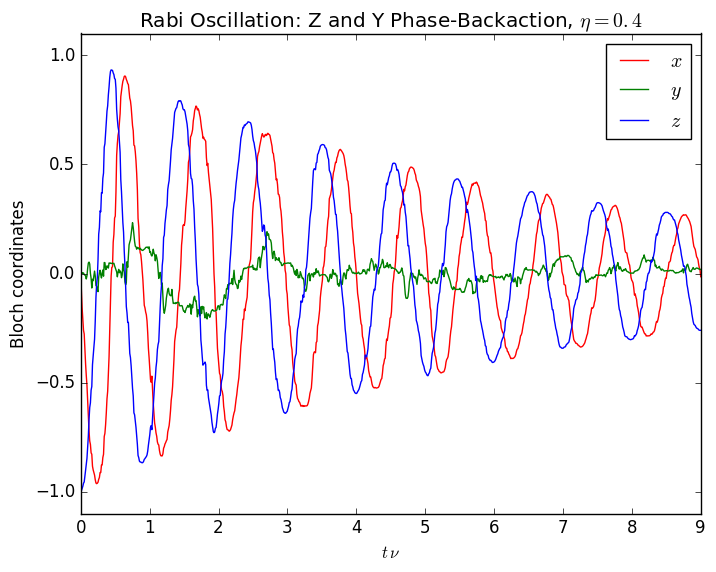

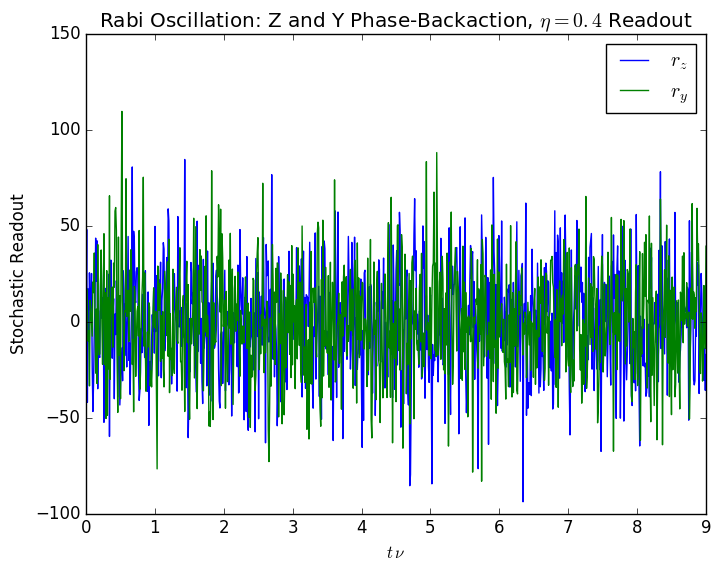

  0.165098 seconds (571.08 k allocations: 45.275 MB, 6.49% gc time)


INFO: Time elapsed: 0.163450591 s, Steps per second: 5500.133064676407


In [17]:
sol = ensemble_realization(ymeas=true, ϕ=π/2, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(ymeas=true, ϕ=π/2, η=0.4)
plot_solution(sol, readout=true, ymeas=true, plot_title=L"Rabi Oscillation: Z and Y Phase-Backaction, $\eta=0.4$")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1


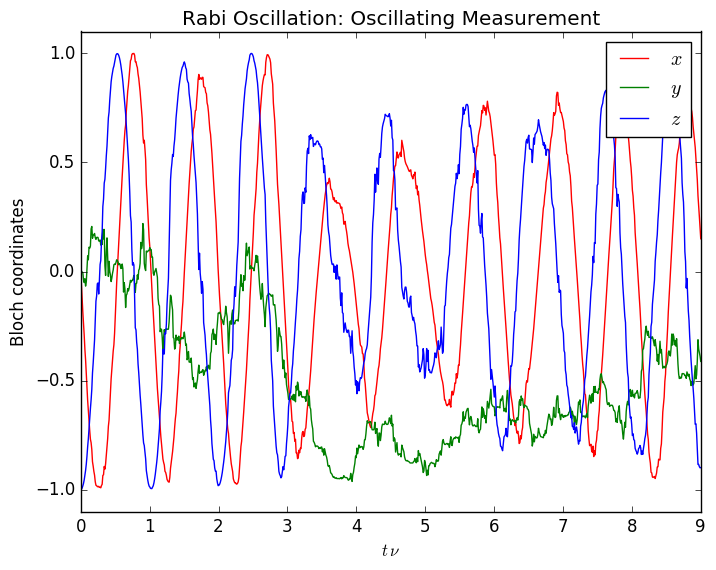

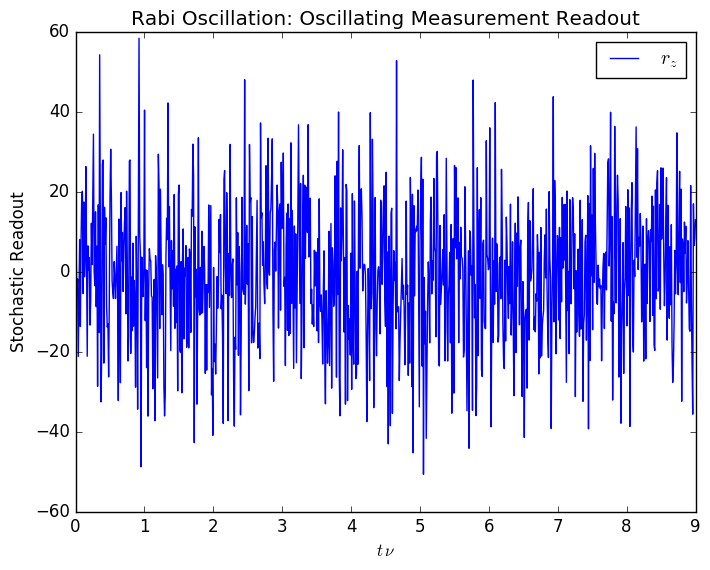

  0.121620 seconds (551.95 k allocations: 33.907 MB, 6.22% gc time)


INFO: Time elapsed: 0.120444392 s, Steps per second: 7464.025390239838


In [18]:
sol = ensemble_realization(tmeas=true, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(tmeas=true)
plot_solution(sol, readout=true, plot_title="Rabi Oscillation: Oscillating Measurement")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1


INFO: Time elapsed: 0.287515246 s, Steps per second: 3126.790709387286


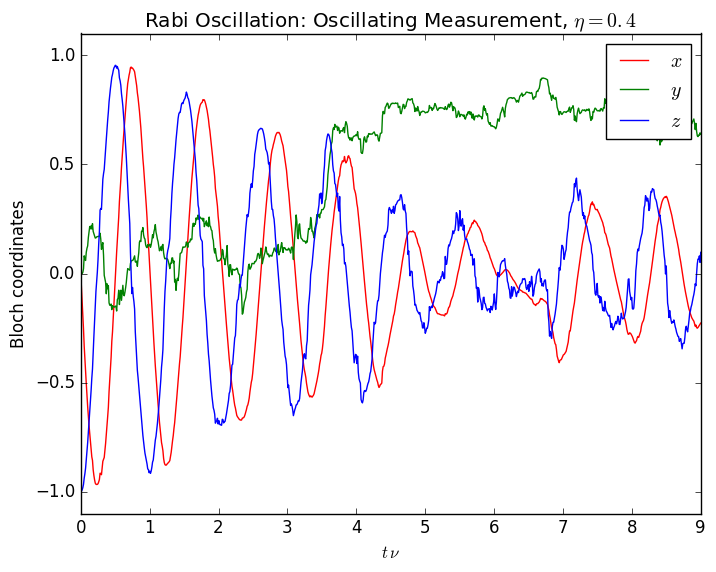

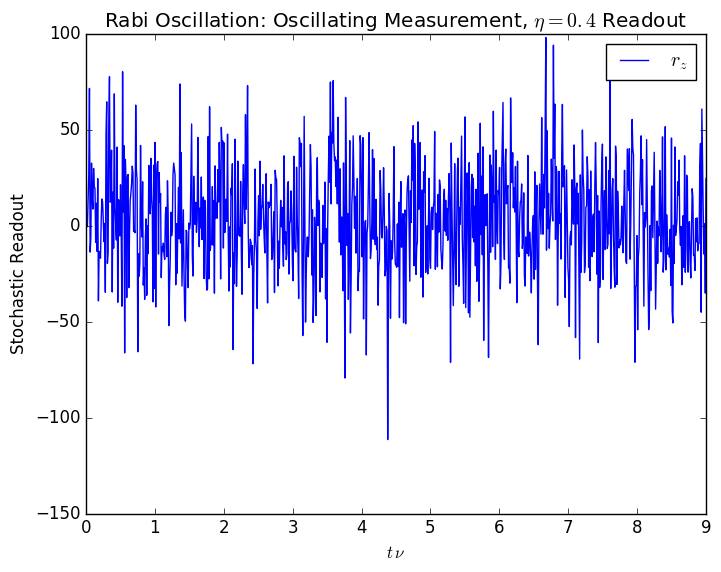

In [19]:
sol = ensemble_realization(tmeas=true, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(tmeas=true, η=0.4)
plot_solution(sol, readout=true, plot_title=L"Rabi Oscillation: Oscillating Measurement, $\eta=0.4$")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1


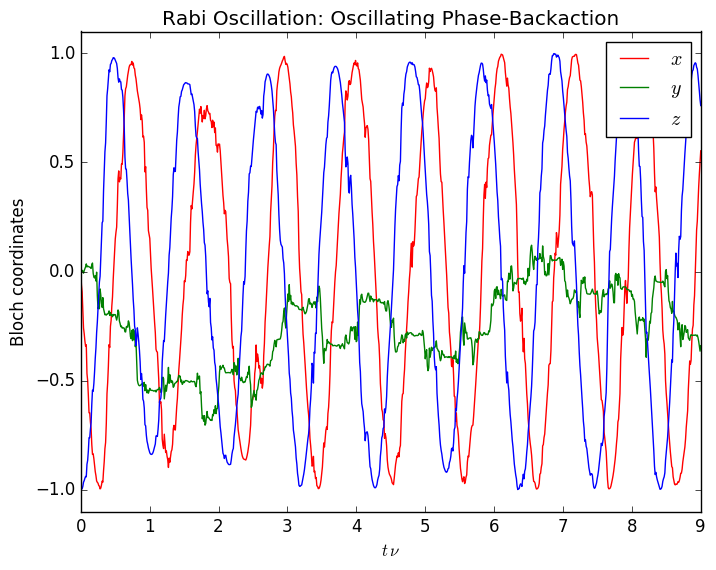

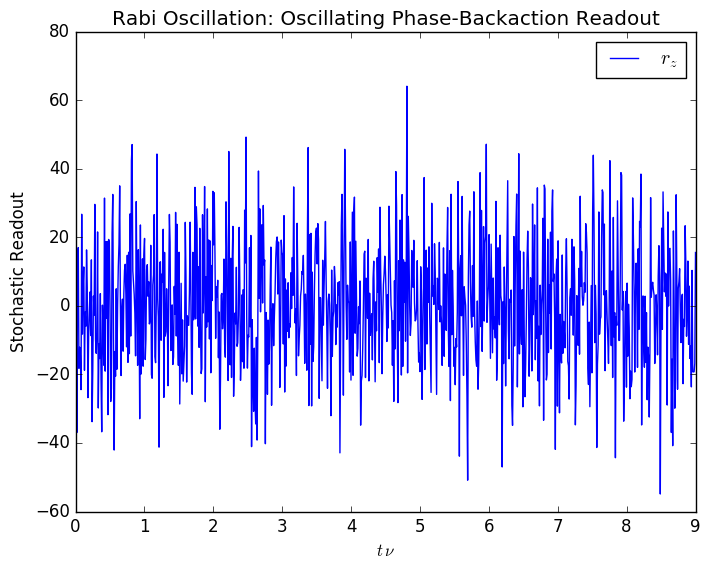

  0.123131 seconds (564.95 k allocations: 33.853 MB, 2.67% gc time)


INFO: Time elapsed: 0.121792029 s, Steps per second: 7381.435446814012


In [20]:
sol = ensemble_realization(tmeas=true, ϕ=π/2, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(tmeas=true, ϕ=π/2)
plot_solution(sol, readout=true, plot_title="Rabi Oscillation: Oscillating Phase-Backaction")

INFO: Trajectory: steps = 899, points = 899, values = 3
INFO: Readout: values = 1


INFO: Time elapsed: 0.292816359 s, Steps per second: 3070.183657327697


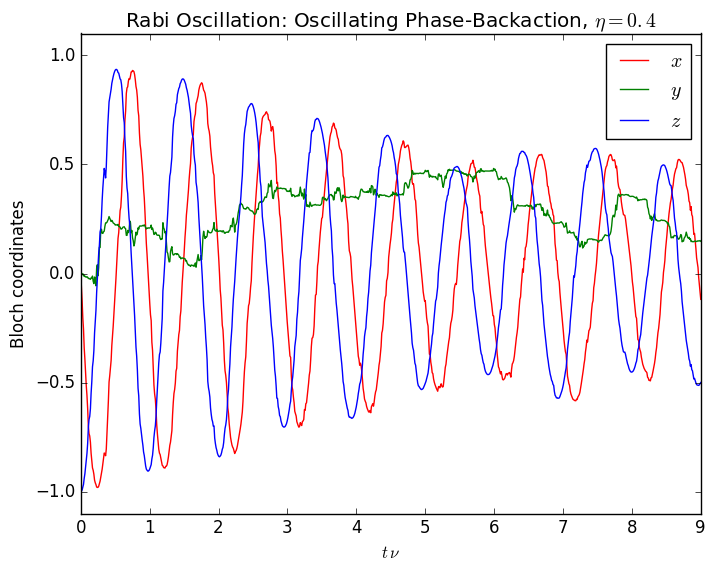

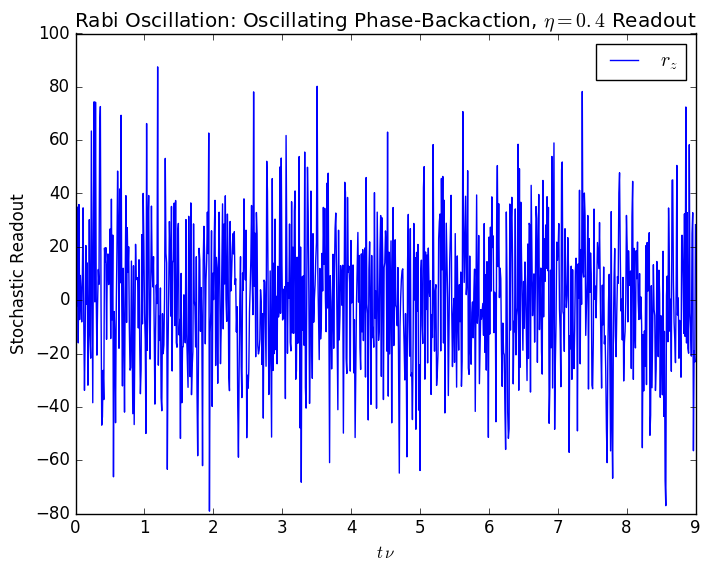

In [21]:
sol = ensemble_realization(tmeas=true, ϕ=π/2, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time sol = ensemble_realization(tmeas=true, ϕ=π/2, η=0.4)
plot_solution(sol, readout=true, plot_title=L"Rabi Oscillation: Oscillating Phase-Backaction, $\eta=0.4$")

### Ensembles of trajectories

In [22]:
# Ensemble size, for easy tunability
num = 2000;

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


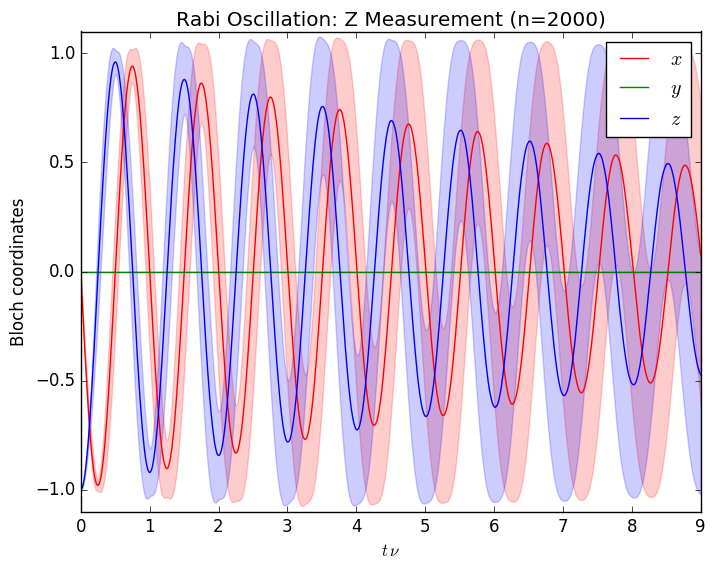

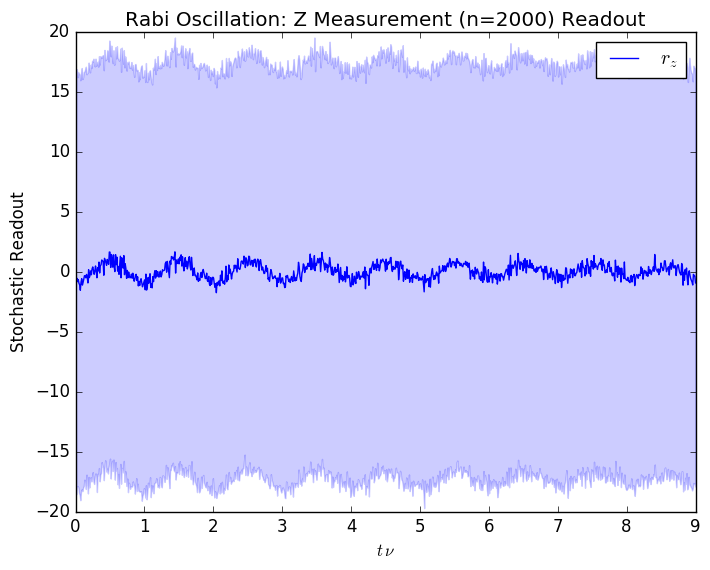

In [23]:
e = ensemble_realization(n=2, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title="Rabi Oscillation: Z Measurement (n=$num)")

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


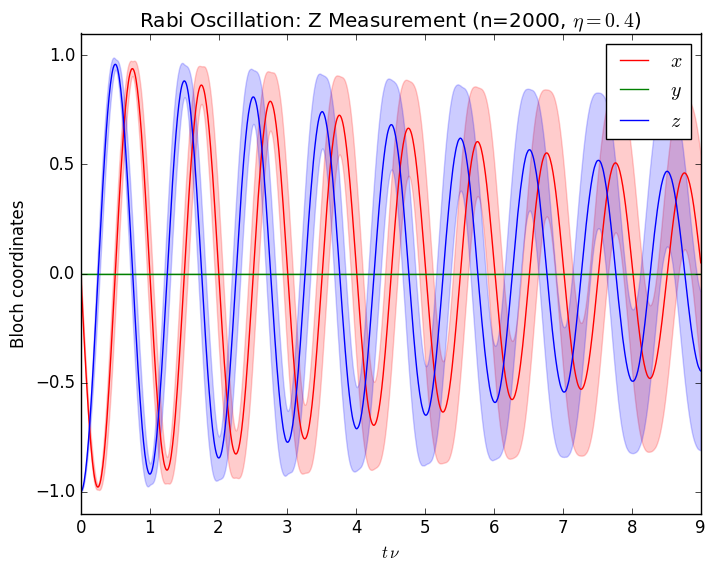

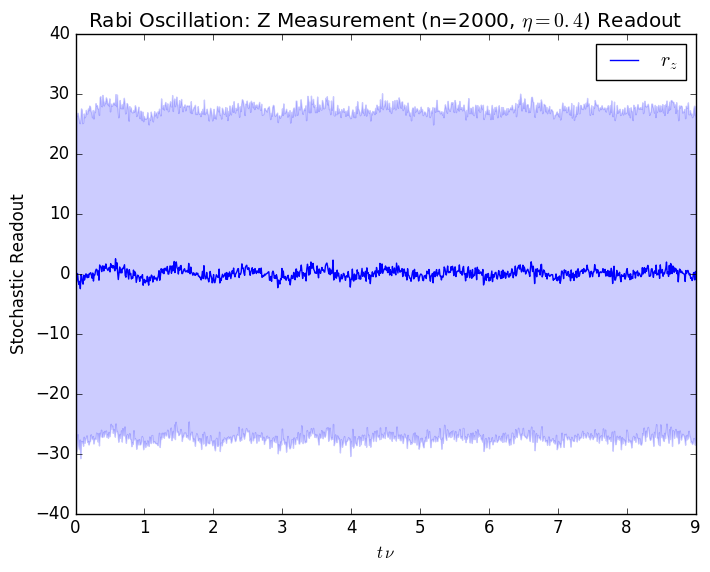

 41.094501 seconds (1.76 M allocations: 152.365 MB, 0.39% gc time)


In [24]:
e = ensemble_realization(n=2, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title=latexstring("Rabi Oscillation: Z Measurement (n=$num, \$\\eta=0.4\$)"))

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


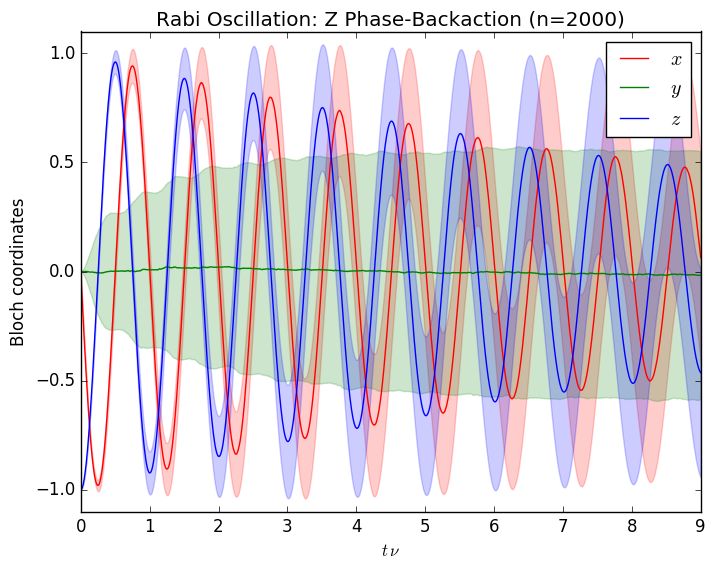

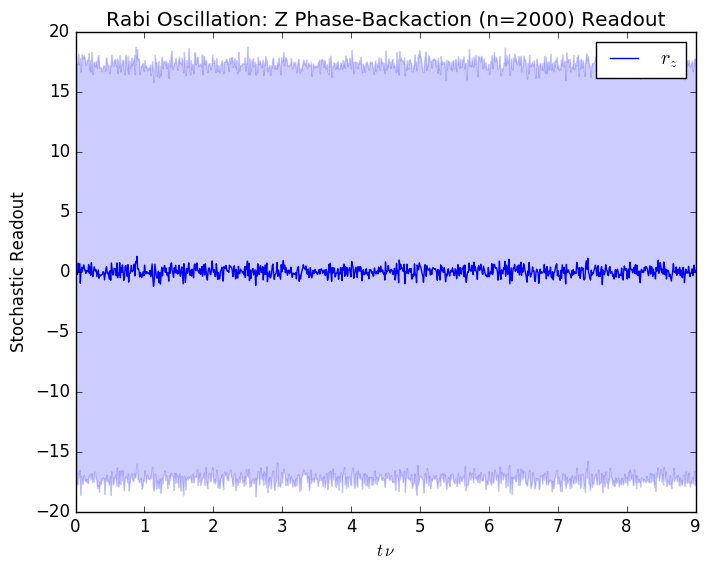

 17.694153 seconds (1.67 M allocations: 150.589 MB, 0.18% gc time)


In [25]:
e = ensemble_realization(n=2, ϕ=π/2, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ϕ=π/2);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title="Rabi Oscillation: Z Phase-Backaction (n=$num)")

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


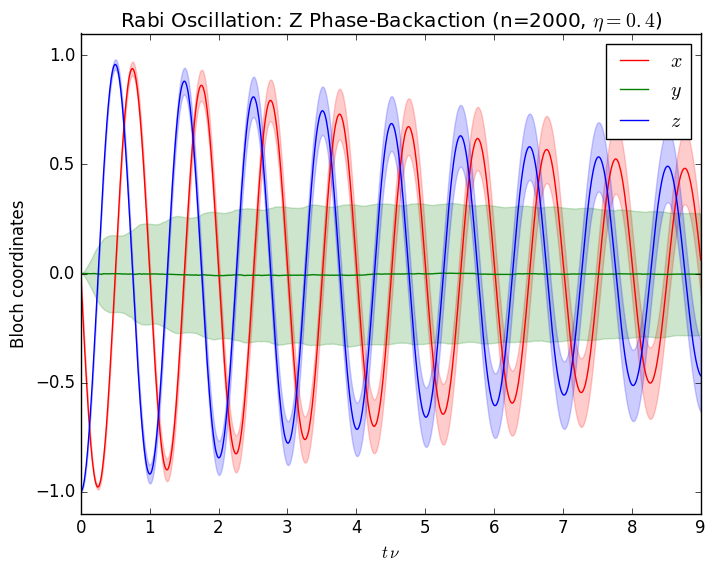

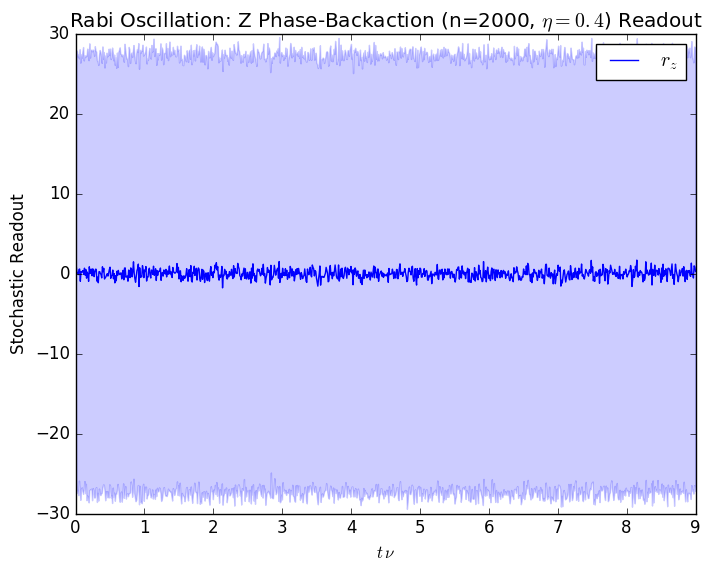

In [26]:
e = ensemble_realization(n=2, ϕ=π/2, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ϕ=π/2, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title=latexstring("Rabi Oscillation: Z Phase-Backaction (n=$num, \$\\eta=0.4\$)"))

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2


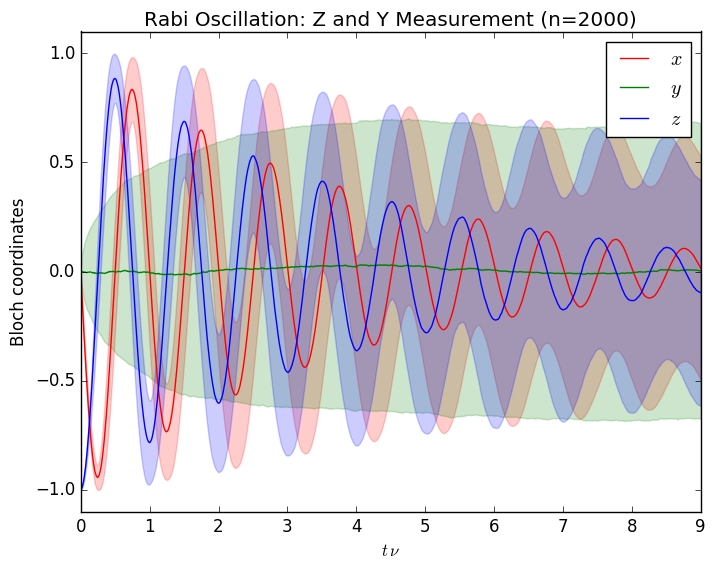

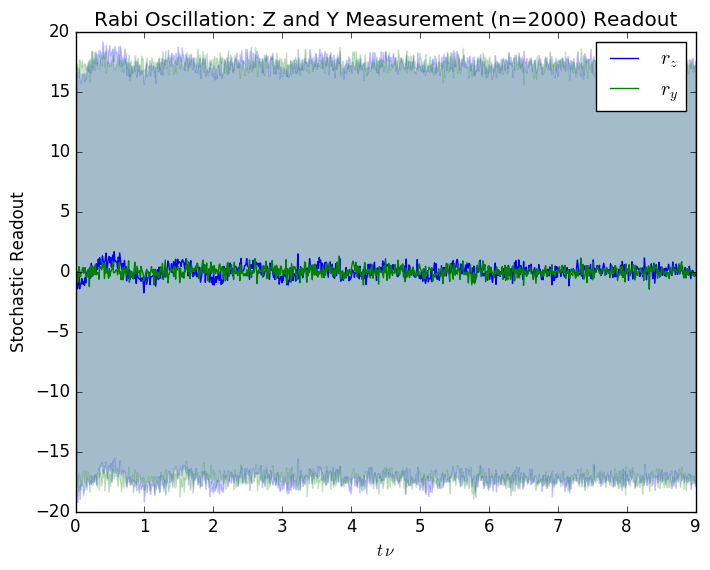

 25.103668 seconds (2.04 M allocations: 185.779 MB, 0.43% gc time)


In [27]:
e = ensemble_realization(n=2, ymeas=true, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Measurement (n=$num)")

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2


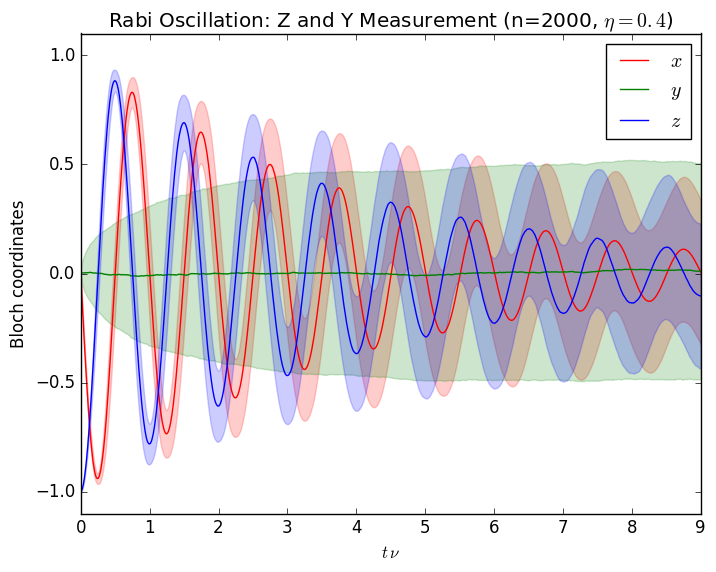

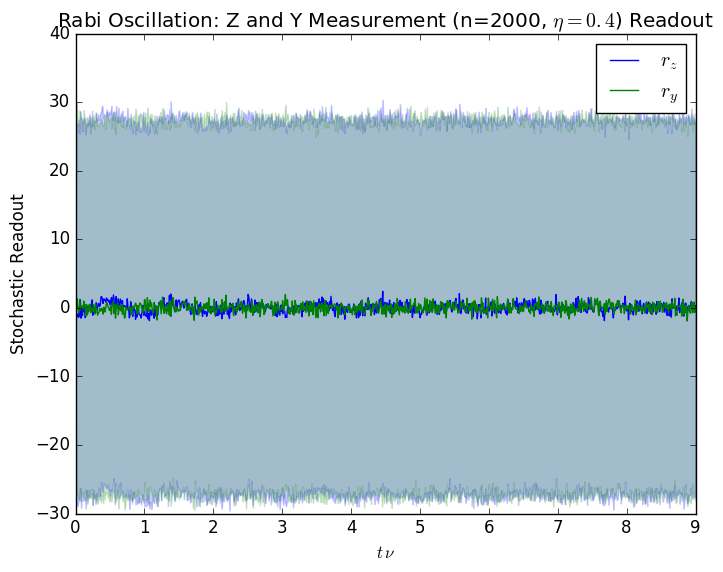

 60.678873 seconds (2.23 M allocations: 189.369 MB, 0.15% gc time)


In [28]:
e = ensemble_realization(n=2, ymeas=true, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title=latexstring("Rabi Oscillation: Z and Y Measurement (n=$num, \$\\eta = 0.4\$)"))

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2


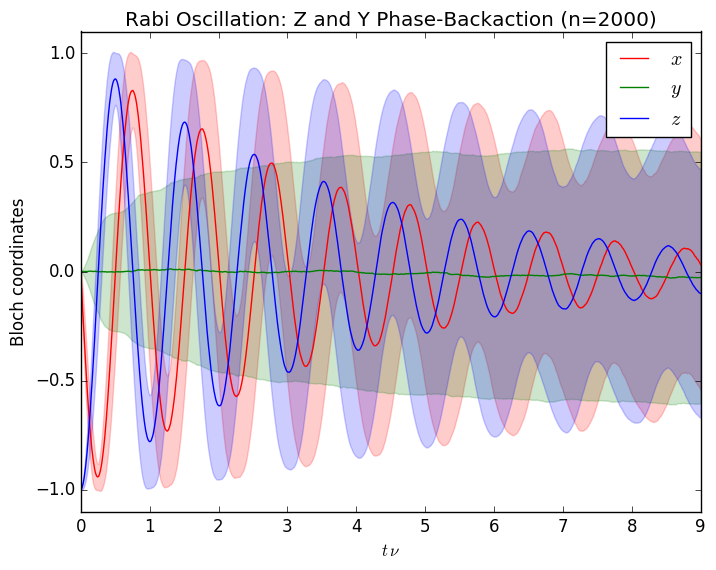

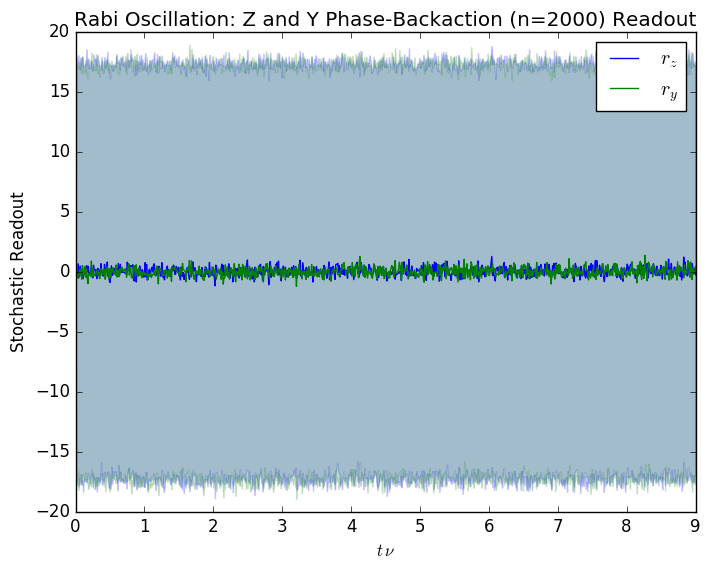

 25.042695 seconds (2.04 M allocations: 185.786 MB, 0.37% gc time)


In [29]:
e = ensemble_realization(n=2, ymeas=true, ϕ=π/2, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true, ϕ=π/2);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title="Rabi Oscillation: Z and Y Phase-Backaction (n=$num)")

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 2


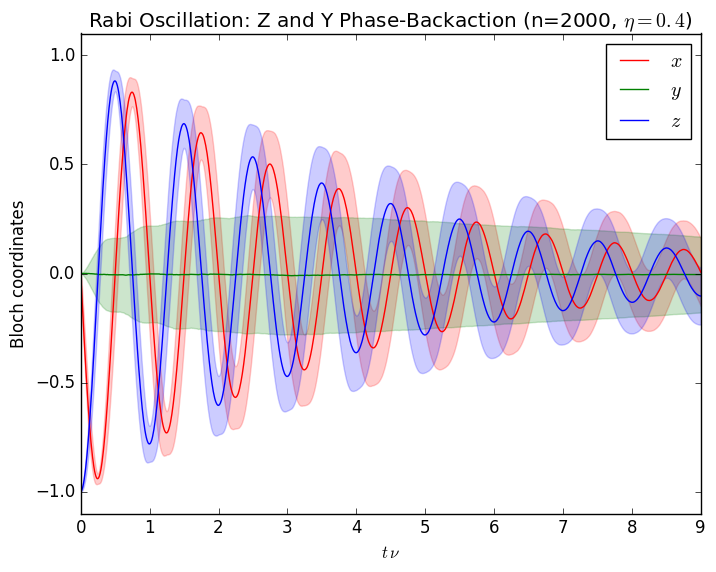

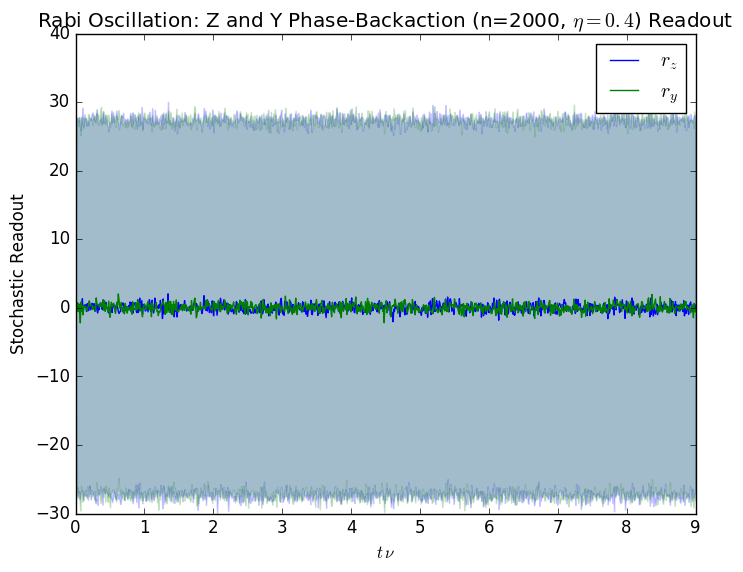

 61.015141 seconds (2.23 M allocations: 189.351 MB, 0.15% gc time)


In [30]:
e = ensemble_realization(n=2, ymeas=true, ϕ=π/2, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, ymeas=true, ϕ=π/2, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, ymeas=true, plot_title=latexstring("Rabi Oscillation: Z and Y Phase-Backaction (n=$num, \$\\eta = 0.4\$)"))

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


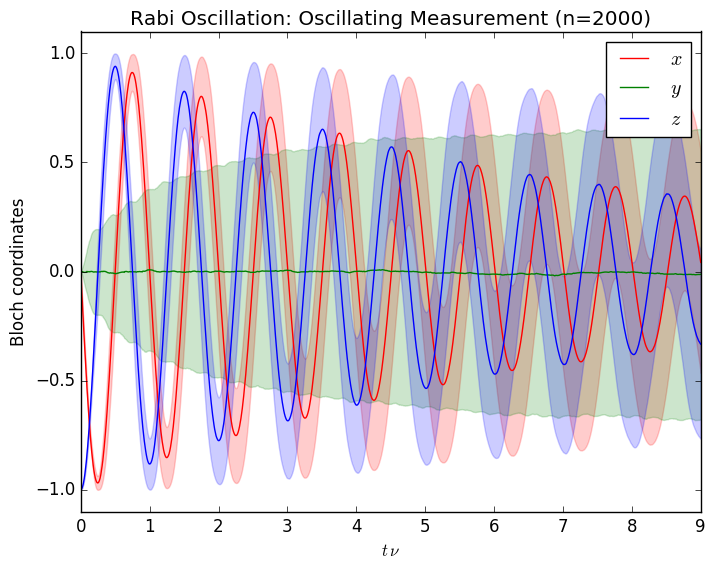

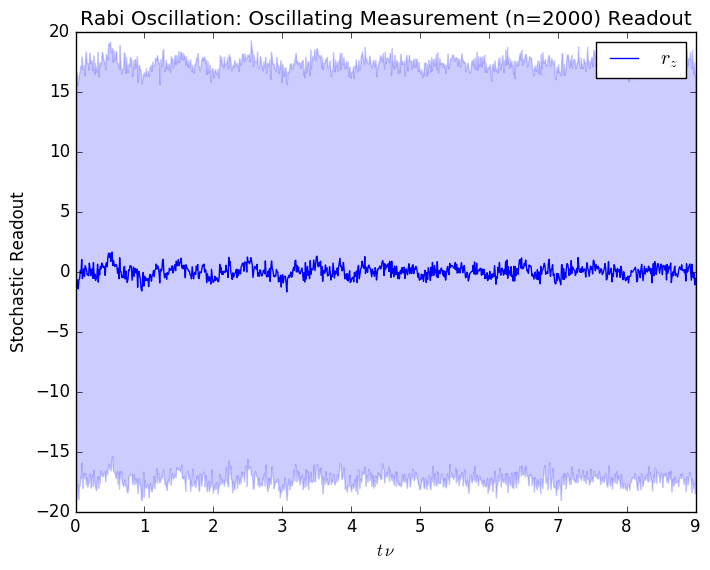

In [31]:
e = ensemble_realization(n=2, tmeas=true, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, tmeas=true);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title="Rabi Oscillation: Oscillating Measurement (n=$num)")

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


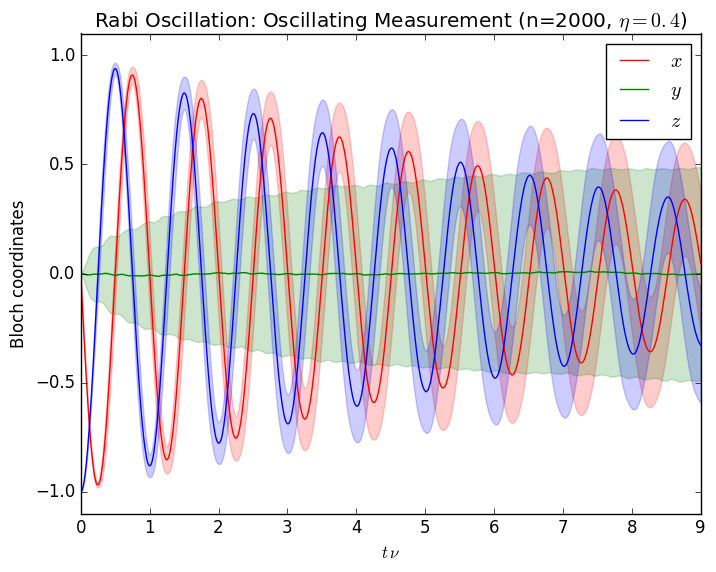

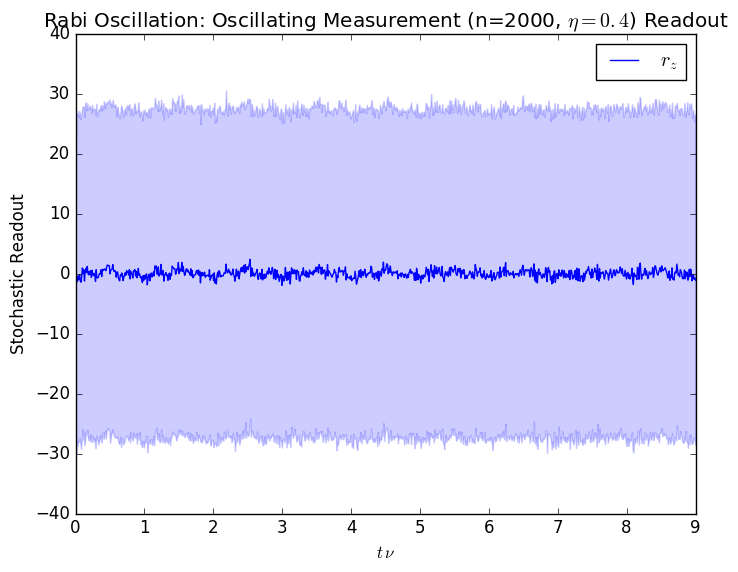

In [32]:
e = ensemble_realization(n=2, tmeas=true, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, tmeas=true, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title=latexstring("Rabi Oscillation: Oscillating Measurement (n=$num, \$\\eta = 0.4\$)"))

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


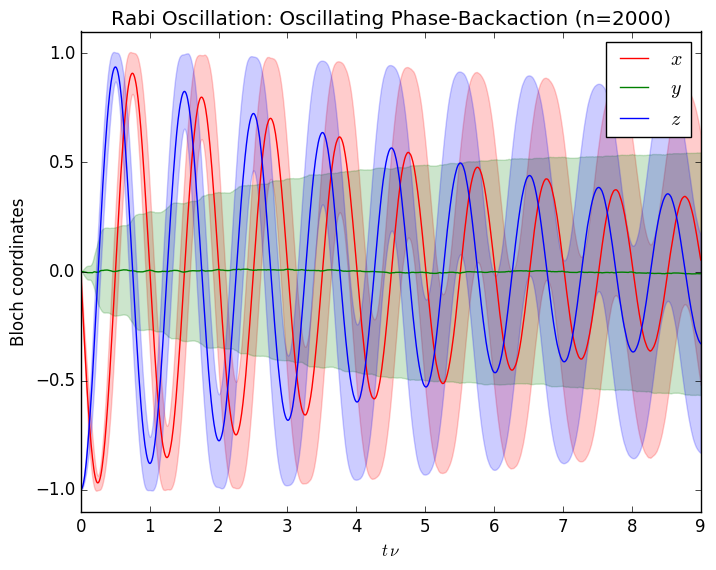

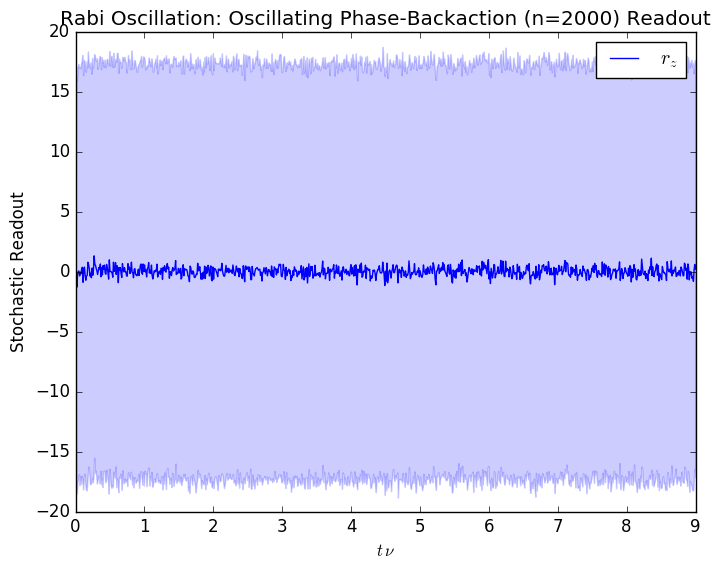

In [33]:
e = ensemble_realization(n=2, tmeas=true, ϕ=π/2, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, tmeas=true, ϕ=π/2);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title="Rabi Oscillation: Oscillating Phase-Backaction (n=$num)")

INFO: Trajectories: 2000, steps each: 899, points each: 899, values each = 3
INFO: Readouts: values each = 1


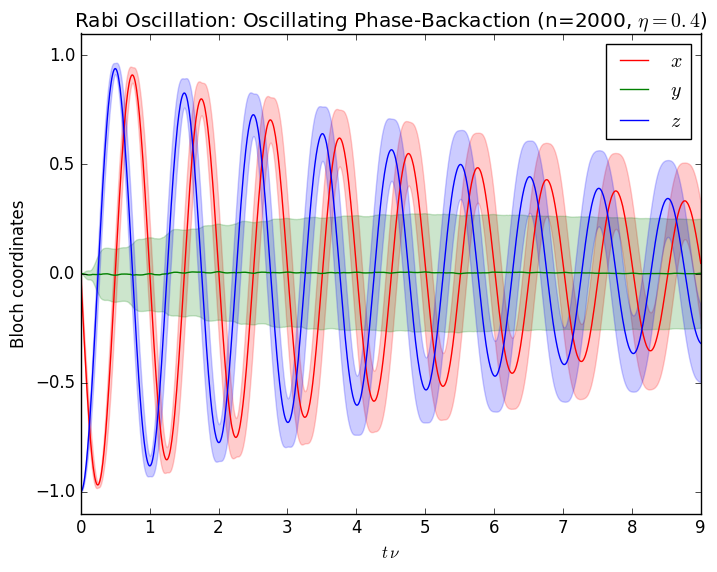

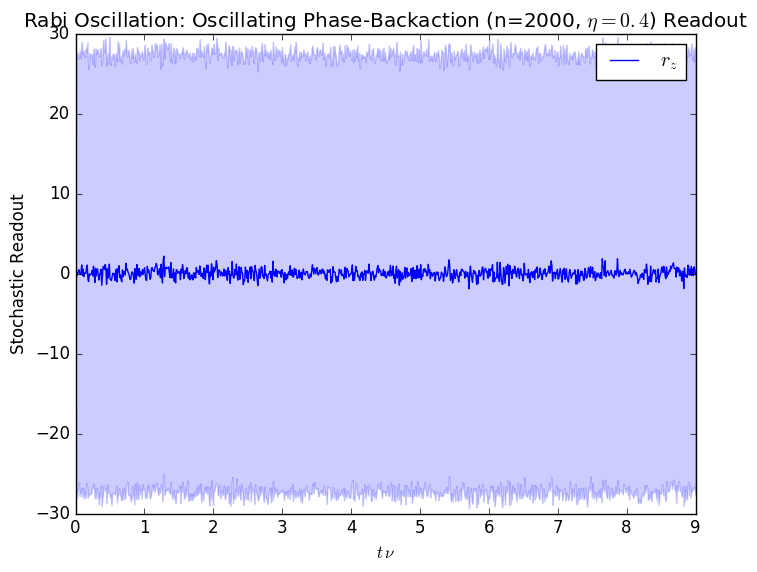

158.047652 seconds (1.53 M allocations: 148.309 MB, 0.06% gc time)


In [34]:
e = ensemble_realization(n=2, tmeas=true, ϕ=π/2, η=0.4, verbose=false) # Run once to JIT-compile before timing
@time e = ensemble_realization(n=num, tmeas=true, ϕ=π/2, η=0.4);
plot_solution(map(mean, e), stds=map(std, e), readout=true, plot_title=latexstring("Rabi Oscillation: Oscillating Phase-Backaction (n=$num, \$\\eta = 0.4\$)"))

## Conclusions

The Quantum Bayesian method for computing stochastic evolution works well and is competitive in speed with the direct Lindblad integration. It is both dramatically faster and much more accurate than any of the currently available stochastic integration solvers in the ```DifferentialEquations``` package.

## Version Information

In [35]:
versioninfo()

Julia Version 0.5.0
Commit 3c9d753 (2016-09-19 18:14 UTC)
Platform Info:
  System: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-4790 CPU @ 3.60GHz
  WORD_SIZE: 64
  BLAS: libopenblas (DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas
  LIBM: libm
  LLVM: libLLVM-3.7.1 (ORCJIT, haswell)


In [36]:
Pkg.installed("PyPlot")

v"2.2.4"

In [37]:
Pkg.installed("QuantumBayesian")

v"0.1.0+"

In [38]:
Pkg.installed("Interpolations")

v"0.3.6"